**Pre-processing**


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
import datetime

#Reading in raw data
df=pd.read_csv('C:/Users/Rory/Downloads/ppd_data.csv',index_col = 'unique_id')
#Keeping copy of raw data
df_old=df
#Changing to datetime format
df['deed_date'] = pd.to_datetime(df['deed_date'])
df['deed_date'].dtype

#Choosing to keep only useful features
df=df[['price_paid','deed_date','postcode','property_type','new_build']]

In [2]:
#Missing values
print(df.isnull().sum())

#Very few missing values, so we will drop them
df.dropna(inplace=True)

price_paid        0
deed_date         0
postcode         91
property_type     0
new_build         0
dtype: int64


C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [3]:
#Simplifying postal code to only be numberic 
df['postcode']=df['postcode'].str.replace(" ","")
df['postcode']=df['postcode'].str.extract("(\d+)")
df['postcode']=df['postcode'].astype('int32')

#Removing postcodes with less than 10 samples
postcode_counts=df['postcode'].value_counts()
to_remove=postcode_counts[postcode_counts<=10].index
# ~ : this operator means to negate
df=df[~df.postcode.isin(to_remove)]

#Shortening price column name
df['price']=df['price_paid']
df_old['price']=df_old['price_paid']

#Shortening date column name
df['date']=df['deed_date']
df_old['date']=df_old['deed_date']

C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

(733773.0, 737425.0)

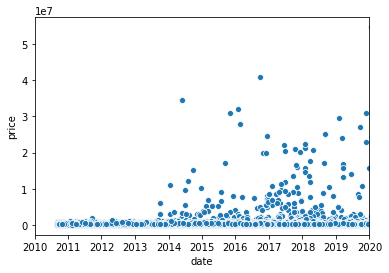

In [4]:
#Scatter plot of price and date over a decade
ax=sns.scatterplot(x="date", y="price", data=df)
ax.set_xlim([datetime.date(2010, 1, 1), datetime.date(2020, 1, 1)])

In [9]:
#Outlier removal - lets get rid of those million pound houses.....

prevmax=df['price'].max()
#Setting up year feature
df['Year']=df['date'].dt.year
#Creating list for outliers to go in
outliers=[]
#3 sigma threshold
threshold=3
#Calculating the median for each year
yr_median=pd.DataFrame(df.groupby(['Year'], as_index=False)['price'].median().set_index('Year'))
#Calculating the standard deviation for each year
yr_std=pd.DataFrame(df.groupby(['Year'], as_index=False).agg({'price':['std']}).set_index('Year'))
#Iterates through each year, using the median and standard deviation for that year to calculate outliers. YEARLY.
for d in df['Year'].unique():                
    for label, row in df.iterrows():
        if row['Year']==d:
            z_score= np.divide(np.subtract(row['price'], (yr_median.values[yr_median.index==d])),(yr_std.values[yr_std.index==d]))
            if np.abs(z_score) > threshold:
                outliers.append(label)
        
#Removing outliers from dataframe
for i in outliers:
    df.drop(i , inplace=True)
newmax=df['price'].max()
#Number of outliers removed
print('Number of outliers removed:')
print(len(outliers))
print('Previous max price: %d  Max price with outliers removed: %.2f' %(prevmax, newmax))

Number of outliers removed:
1042
Previous max price: 2935000  Max price with outliers removed: 700000.00


Text(0.5,1,'Post-outlier removal')

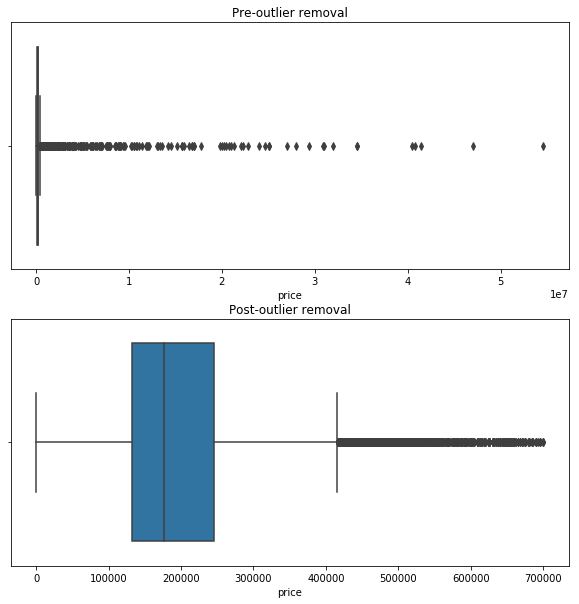

In [10]:
#Outlier removal boxplots
f, axes=plt.subplots(2,1, figsize=(10,10))
sns.boxplot(x="price", data=df_old, ax=axes[0]).set_title('Pre-outlier removal')
sns.boxplot(x="price", data=df, ax=axes[1]).set_title('Post-outlier removal')

[734016.0, 737612.0, 734016.0, 737612.0]

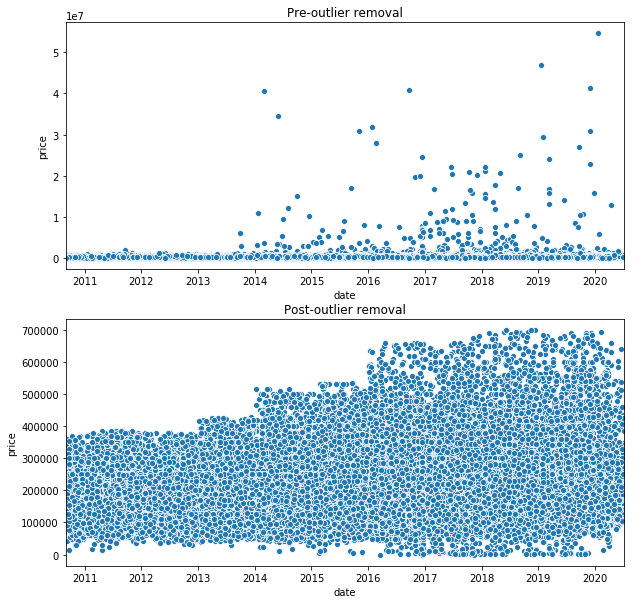

In [11]:
#Outlier removal scatter plots
f, axes=plt.subplots(2,1, figsize=(10,10))
sns.scatterplot(x="date", y="price", data=df_old,ax=axes[0]).set_title('Pre-outlier removal')
sns.scatterplot(x="date", y="price", data=df, ax=axes[1]).set_title('Post-outlier removal')
custom_xlim=([df['date'].min(), df['date'].max()])
plt.setp(axes,xlim=custom_xlim)


**Explatory Data Analysis**

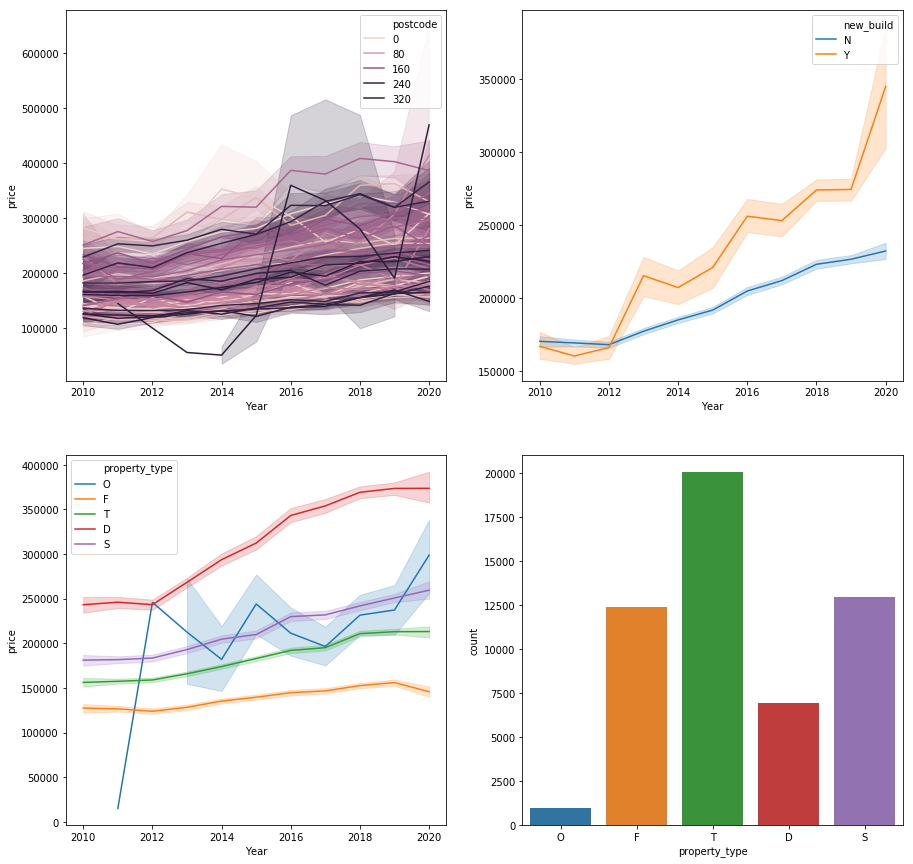

In [12]:
#Subplots of features
f, axes= plt.subplots(2,2, figsize=(15,15))
sns.lineplot(x="Year", y="price", hue="postcode", data=df, ax=axes[0,0])
sns.lineplot(x="Year", y="price", hue="property_type", data=df,ax=axes[1,0])
sns.lineplot(x="Year", y="price", hue="new_build", data=df,ax=axes[0,1])
sns.countplot(x="property_type", data=df,ax=axes[1,1])

In [17]:
df.groupby(['postcode'], as_index=False)['price'].mean().set_index('postcode')

,price
postcode,
30,154346.060290
31,136333.158177
32,299330.027559
33,163213.237379
34,152954.563657
35,164992.222222
36,268284.607973
51,215806.872521
52,231782.848242


In [ ]:
df['binlabels'], binedges=pd.qcut(df['price'],30,labels=False, retbins=True)
replacer=list(range(0,30))
for i in replacer:
    df['binlabels'].replace(i, binedges[i], inplace=True)
ptype=pd.get_dummies(data=df['property_type'],prefix="ptype")
new=pd.get_dummies(data=df['new_build'],prefix="new")
df=pd.concat([df,ptype,new],axis=1)
df['pricebinned']=df['binlabels']
df.drop(['property_type','new_build','price_paid','deed_date','price','binlabels'],axis=1,inplace=True)

In [ ]:
df.head()

In [ ]:
heatmapcorr=df.corr()
sns.set(rc={'figure.figsize':(40,40)})
sns.heatmap(heatmapcorr, annot=True)

In [ ]:
from sklearn.model_selection import train_test_split

Y=df['pricebinned'].values
X=df.drop(['pricebinned'],axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=42)

In [ ]:
for i in range (0,len(y_train)):
    y_train[i]=int(y_train[i])

In [ ]:
for i in range (0,len(y_test)):
    y_test[i]=int(y_test[i])

In [ ]:
print(X_train.size)
print(X_test.size)
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Using Success and Failure for 0 and 1    
class_names = ['Success','Failure']

In [ ]:
from sklearn.metrics import classification_report, recall_score,confusion_matrix,roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors  import KNeighborsClassifier

forest=RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=10, class_weight="balanced").fit(X_train, y_train)
rf_yhat=forest.predict(X_test)
std=np.std(rf_yhat==y_test)/np.sqrt(rf_yhat.shape[0])
print("Standard Deviation= %2.4f"% std)
class_forest=classification_report(y_test, rf_yhat)



In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
lr=LogisticRegression().fit(X_train, y_train)
lr_yhat=lr.predict(X_test)
std=np.std(lr_yhat==y_test)/np.sqrt(lr_yhat.shape[0])
print("Standard Deviation= %2.4f"% std)
class_lr=classification_report(y_test, lr_yhat)
print(class_lr)

In [ ]:
cm_lr=confusion_matrix(y_test,lr_yhat)
plot_confusion_matrix(cm_lr, classes=class_names, title='Confusion Matrix LR')

In [ ]:
gb=GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01).fit(X_train, y_train)
gb_yhat=gb.predict(X_test)
std=np.std(gb_yhat==y_test)/np.sqrt(gb_yhat.shape[0])
print("Standard Deviation= %2.4f"% std)
class_gb=classification_report(y_test, gb_yhat)


In [ ]:
print(class_gb)

In [ ]:
cm_gb=confusion_matrix(y_test,gb_yhat)
plot_confusion_matrix(cm_gb, classes=class_names, title='Confusion Matrix GB')

In [ ]:
rf=RandomForestClassifier().fit(X_train, y_train)
rf_yhat=rf.predict(X_test)
std=np.std(rf_yhat==y_test)/np.sqrt(rf_yhat.shape[0])
print("Standard Deviation= %2.4f"% std)
class_rf=classification_report(y_test, rf_yhat)
print(class_rf)

In [ ]:
cm_rf=confusion_matrix(y_test,rf_yhat)
plot_confusion_matrix(cm_rf, classes=class_names, title='Confusion Matrix RF')

In [ ]:
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
# Calcualting important features in the model
importances = model.feature_importances_
feat_names = df.drop(['pricebinned'],axis=1).columns

# Displaying the feature importances as a chart by sorting it in the order of importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()